# RDS HW3 Template

Install the Data Synthesizer library.

# Section

In [1]:
!pip install DataSynthesizer

In [2]:
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import normalize_given_distribution, read_json_file, pairwise_attributes_mutual_information, mutual_information, set_random_seed

from IPython.display import clear_output
from scipy.stats import entropy, ks_2samp
from scipy.spatial.distance import euclidean
from sklearn.metrics import mutual_info_score
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

import DataSynthesizer.DataGenerator as dg
dg.np = np

In [3]:
def generate_data_A(input_data_file, output_data_size, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['A']

    describer = DataDescriber()
    describer.describe_dataset_in_random_mode(input_data_file, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_random_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [4]:
def generate_data_B(input_data_file, output_data_size, epsilon=0.1, seed=None):
    seed = seed or randint(0, 2**30)
    description_file = description_files['B']

    describer = DataDescriber()
    describer.describe_dataset_in_independent_attribute_mode(input_data_file, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_independent_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

In [5]:
def generate_data_CD(input_data_file, output_data_size, description_file, epsilon=0.5, k=1, seed=None):
    seed = seed or randint(0, 2**30)

    describer = DataDescriber()
    describer.describe_dataset_in_correlated_attribute_mode(input_data_file, k=k, epsilon=epsilon, seed=seed)
    describer.save_dataset_description_to_file(description_file)

    generator = DataGenerator()
    generator.generate_dataset_in_correlated_attribute_mode(output_data_size, description_file, seed=seed)
    return generator.synthetic_dataset

def generate_data_C(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['C'], epsilon, k=1, seed=seed)

def generate_data_D(input_data_file, output_data_size, epsilon=0.1, seed=None):
    return generate_data_CD(input_data_file, output_data_size, description_files['D'], epsilon, k=2, seed=seed)

Start with a real dataset __hw_compas__ and a fake dataset __hw_xyz__. Generate synthetic datasets of size __N=10000__, in the following four categories:
- A:  random mode
- B: independent attribute mode with __epsilon = 0.1__
- C:  correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=1
- D: correlated attribute mode with __epsilon = 0.1__, Bayes net degree k=2

In [6]:
# Packages for reading csv file into Colaboratory:
!pip install -U -q PyDrive==1.3.1

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# Please follow the steps as instructed when you run the following commands.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileid_compas = '1kgSIBkOM9y0nz_l8LI8ze9TAhF5gbb64'
real_data_file = 'hw_compas.csv'

fileid_fake = '1b_T0SHQUMbVvZueZ6yXlxTKBHctMgM0k'
fake_data_file = 'hw_fake.csv'

downloaded = drive.CreateFile({'id':fileid_compas})
downloaded.GetContentFile(real_data_file)
df_real = pd.read_csv(real_data_file)

downloaded = drive.CreateFile({'id':fileid_fake})
downloaded.GetContentFile(fake_data_file)
df_fake = pd.read_csv(fake_data_file)

In [8]:
output_data_size = 10000
epsilon = 0.1

seed = 0  # make the entire notebook reproducible

description_files = {'A': './descrption_A.json',
                     'B': './descrption_B.json',
                     'C': './descrption_C.json',
                     'D': './descrption_D.json'}

set_random_seed(seed)

df_real_A = generate_data_A(real_data_file, output_data_size)
df_real_B = generate_data_B(real_data_file, output_data_size, epsilon=epsilon)
df_real_C = generate_data_C(real_data_file, output_data_size, epsilon=epsilon)
df_real_D = generate_data_D(real_data_file, output_data_size, epsilon=epsilon)

df_fake_A = generate_data_A(fake_data_file, output_data_size)
df_fake_B = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_C = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon)
df_fake_D = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon)

clear_output()

## Part (a)

### Q1

Median, Mean, Min, Max of __age__ and __score__ for each A, B, C and D, compare to the ground truth value in __hw_compas__, present results in a table

In [9]:
# Calculate Median, Mean, Min, Max of age and score for datasets A, B, C, D

def calculate_statistics(df, attributes):
    """Calculate basic statistics for given attributes in a dataframe"""
    stats = {}
    for attr in attributes:
        stats[attr] = {
            'Median': df[attr].median(),
            'Mean': df[attr].mean(),
            'Min': df[attr].min(),
            'Max': df[attr].max()
        }
    return stats

# Calculate statistics for the original hw_compas dataset
compas_stats = calculate_statistics(df_real, ['age', 'score'])

# Calculate statistics for synthetic datasets
compas_A_stats = calculate_statistics(df_real_A, ['age', 'score'])
compas_B_stats = calculate_statistics(df_real_B, ['age', 'score'])
compas_C_stats = calculate_statistics(df_real_C, ['age', 'score'])
compas_D_stats = calculate_statistics(df_real_D, ['age', 'score'])

# Create a table to display results
def create_stats_table(original_stats, synthetic_stats_list, names, attributes):
    """Create a table comparing original and synthetic dataset statistics"""
    results = {}
    for attr in attributes:
        attr_results = {'Original': original_stats[attr]}
        for i, stats in enumerate(synthetic_stats_list):
            attr_results[names[i]] = stats[attr]
        results[attr] = pd.DataFrame(attr_results)
    return results

# Create tables for age and score
stats_tables = create_stats_table(
    compas_stats,
    [compas_A_stats, compas_B_stats, compas_C_stats, compas_D_stats],
    ['A: Random', 'B: Independent', 'C: Correlated (k=1)', 'D: Correlated (k=2)'],
    ['age', 'score']
)

# Display tables
print("Statistics for age:")
display(stats_tables['age'])
print("\nStatistics for score:")
display(stats_tables['score'])

Statistics for age:


,Original,A: Random,B: Independent,C: Correlated (k=1),D: Correlated (k=2)
Median,32.000000,51.0000,33.0000,36.0000,39.0000
Mean,35.143319,50.1731,35.7354,41.5788,44.1532
Min,18.000000,0.0000,18.0000,18.0000,18.0000
Max,96.000000,100.0000,76.0000,96.0000,96.0000



Statistics for score:


,Original,A: Random,B: Independent,C: Correlated (k=1),D: Correlated (k=2)
Median,4.000000,5.0000,4.0000,5.0000,4.000
Mean,4.371268,4.9392,4.3657,4.9487,4.466
Min,-1.000000,-1.0000,1.0000,-1.0000,-1.000
Max,10.000000,10.0000,10.0000,10.0000,10.000


For the attribute age, method B performs the best in that it differs not much from the real dataset in aspects of median, mean, min; method A performs the worst since its much different from the real values. method C and D are rather OK in accuracy but still yields higher medians and means.

For the attribute score, method D yields the most accurate results, while method A, B, and C all deviates in at least one of the metrics for a bit, while still achieving rather high accuracy.
Method A (random mode) is the most off in age because it ignores the underlying distribution entirely; method B is the best in age because it considers the distribution and little noise is added; while method C and D add noise to populate many conditional tables, pushing the age distribution off.

### Q2

Some more sophisticated statistical measure that’s good for independent attribute mode - __Two-sample Kolmogorov–Smirnov test__ and __KL-divergence__. Also show the difference visually, comparing real vs. synthetic

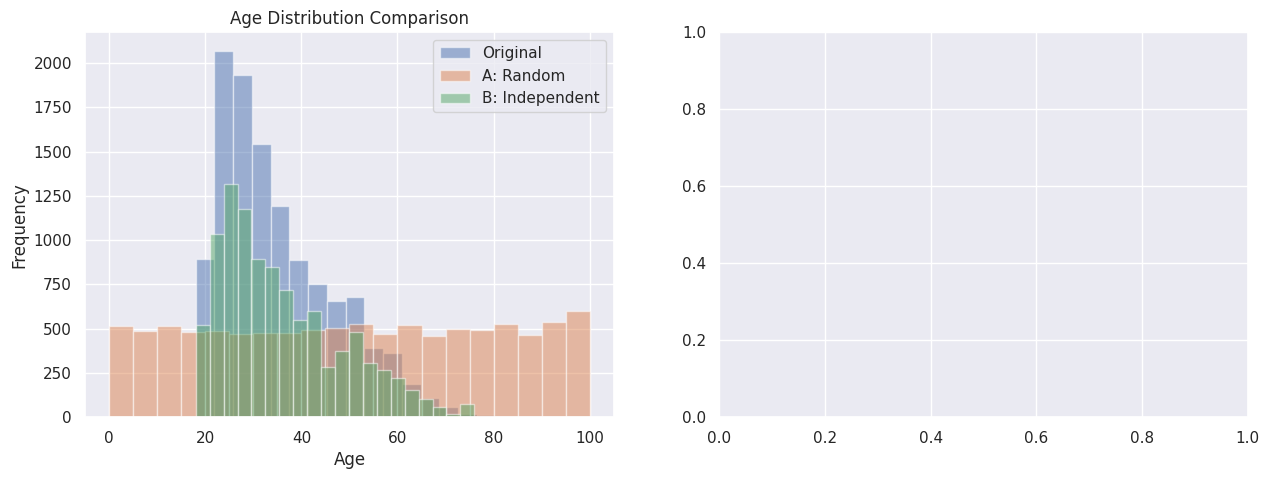

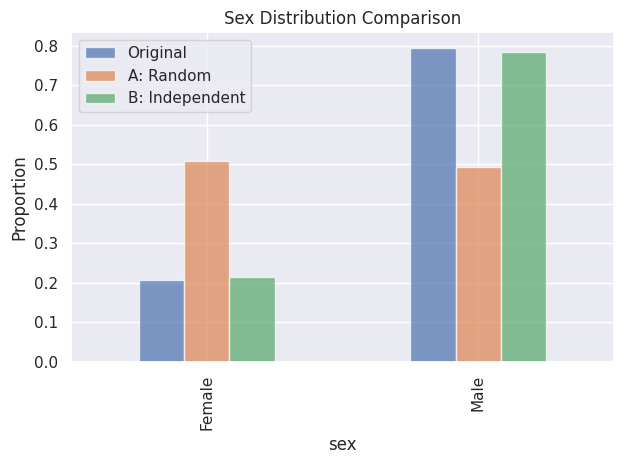

In [10]:


# Plot distributions of age for original and synthetic datasets A and B
plt.figure(figsize=(15, 5))

# Age distribution
plt.subplot(1, 2, 1)
plt.hist(df_real['age'], bins=20, alpha=0.5, label='Original')
plt.hist(df_real_A['age'], bins=20, alpha=0.5, label='A: Random')
plt.hist(df_real_B['age'], bins=20, alpha=0.5, label='B: Independent')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.title('Age Distribution Comparison')

# Sex distribution
plt.subplot(1, 2, 2)
sex_counts = pd.DataFrame({
    'Original': df_real['sex'].value_counts(normalize=True),
    'A: Random': df_real_A['sex'].value_counts(normalize=True),
    'B: Independent': df_real_B['sex'].value_counts(normalize=True)
})
sex_counts.plot(kind='bar', alpha=0.7)
plt.ylabel('Proportion')
plt.title('Sex Distribution Comparison')
plt.tight_layout()
plt.show()

#### Two-sample Kolmogorov–Smirnov test for continous attributes

In [11]:
def ks_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for Two-sample Kolmogorov–Smirnov test.
    """
    return ks_2samp(df_in[attr], df_out[attr])[0]

# Perform KS test for age
ks_score_A = ks_test(df_real, df_real_A, 'age')
ks_score_B = ks_test(df_real, df_real_B, 'age')
print(f"KS test score for age (A): {ks_score_A}")
print(f"KS test score for age (B): {ks_score_B}")

KS test score for age (A): 0.3735091775112699
KS test score for age (B): 0.026252445351705345


#### KL-divergence for categorical attributes

In [12]:
def get_distribution_of_categorical_attribute(attribute: pd.Series, indicies=None):
    distribution = attribute.dropna().value_counts()
    if indicies is not None:
        for idx in set(indicies) - set(distribution.index):
            distribution.loc[idx] = 0
    distribution.sort_index(inplace=True)
    return distribution/sum(distribution)

def kl_test(df_in: pd.DataFrame, df_out: pd.DataFrame, attr: str):
    """
    df_in: the sensitive dataset
    df_out: the synthetic dataset
    attr: the attribute that will be calculated for KL-divergence.
    """
    distribution_in = get_distribution_of_categorical_attribute(df_in[attr])
    distribution_out = get_distribution_of_categorical_attribute(df_out[attr], distribution_in.index)
    return entropy(distribution_out, distribution_in)

# Perform KL divergence test for sex
kl_score_A = kl_test(df_real, df_real_A, 'sex')
kl_score_B = kl_test(df_real, df_real_B, 'sex')
print(f"KL divergence score for sex (A): {kl_score_A}")
print(f"KL divergence score for sex (B): {kl_score_B}")

KL divergence score for sex (A): 0.22319792405369002
KL divergence score for sex (B): 0.0002494300869420492


The age distribution comparison shows independent mode (B) closely matching the original distribution, confirmed by a low KS test score of 0.026.

The random mode (A) completely fails to reproduce the distribution pattern, showing a uniform distribution instead of the original right-skewed one, with a high KS score of 0.374.

For the sex attribute, the KL divergence scores similarly confirm B's superiority (0.0002) over A (0.223). Overall, independent mode preserves both numerical and categorical distributions significantly better than random mode.

### Q3

some more sophisticated statistical measure that’s good for correlated attribute mode, and will be better with k=2 (case D) than with k=1 (case C), __some distance over pairwise correlation coefficients? Also show the difference visually, comparing results on real vs. synthetic datasets__.

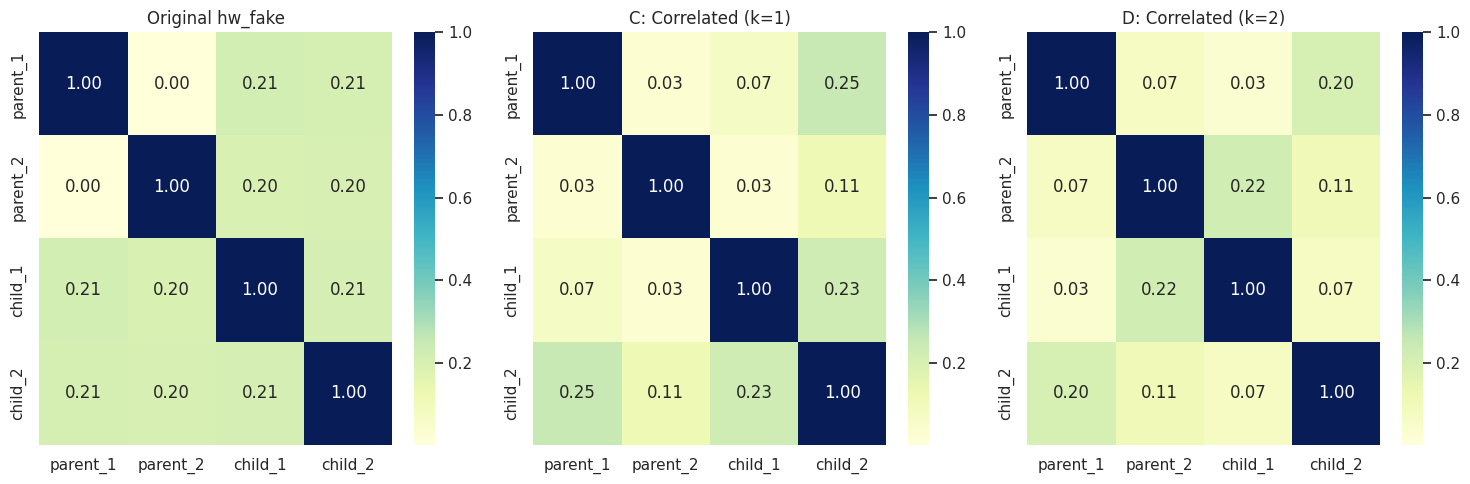

In [13]:
# Compare accuracy of correlated attribute mode with k=1 (C) and k=2 (D) for hw_fake

# Use the pairwise_attributes_mutual_information function directly instead of creating a new function
# This function is already defined in the DataSynthesizer library

# Calculate mutual information matrices
mi_original = pairwise_attributes_mutual_information(df_fake)
mi_C = pairwise_attributes_mutual_information(df_fake_C)
mi_D = pairwise_attributes_mutual_information(df_fake_D)

# Convert to DataFrames for easier plotting
mi_original_df = pd.DataFrame(mi_original, index=df_fake.columns, columns=df_fake.columns)
mi_C_df = pd.DataFrame(mi_C, index=df_fake.columns, columns=df_fake.columns)
mi_D_df = pd.DataFrame(mi_D, index=df_fake.columns, columns=df_fake.columns)

# Plot heatmaps
plt.figure(figsize=(15, 5))

# Set consistent color scale
vmin = min(np.min(mi_original), np.min(mi_C), np.min(mi_D))
vmax = max(np.max(mi_original), np.max(mi_C), np.max(mi_D))

plt.subplot(1, 3, 1)
sns.heatmap(mi_original_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title('Original hw_fake')

plt.subplot(1, 3, 2)
sns.heatmap(mi_C_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title('C: Correlated (k=1)')

plt.subplot(1, 3, 3)
sns.heatmap(mi_D_df, annot=True, fmt=".2f", cmap="YlGnBu", vmin=vmin, vmax=vmax)
plt.title('D: Correlated (k=2)')

plt.tight_layout()
plt.show()

The mutual information heatmaps show neither correlated mode perfectly captures the relationships in the original data.

Mode C (k=1) overestimates certain relationships (parent_1 to child_2) while underestimating others. Mode D (k=2), despite higher complexity, doesn't consistently improve preservation and even underestimates some important correlations.

Both methods incorrectly introduce correlation between parent variables and fail to maintain the equal dependencies between parents and children present in the original data.


## Part (b)

Study the variability in accuracy of answers to Q1 and Q2 for A, B and C: fix epsilon = 0.1, generate __10__ synthetic databases (by specifying different seeds).  Plot accuracy as a box-and-whiskers plot.  

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attrib

<ipython-input-14-59ff03172c33>:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=['A: Random', 'B: Independent', 'C: Correlated (k=1)'],
<ipython-input-14-59ff03172c33>:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=['A: Random', 'B: Independent', 'C: Correlated (k=1)'],
<ipython-input-14-59ff03172c33>:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=['A: Random', 'B: Independent', 'C: Correlated (k=1)'],
<ipython-input-14-59ff03172c33>:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

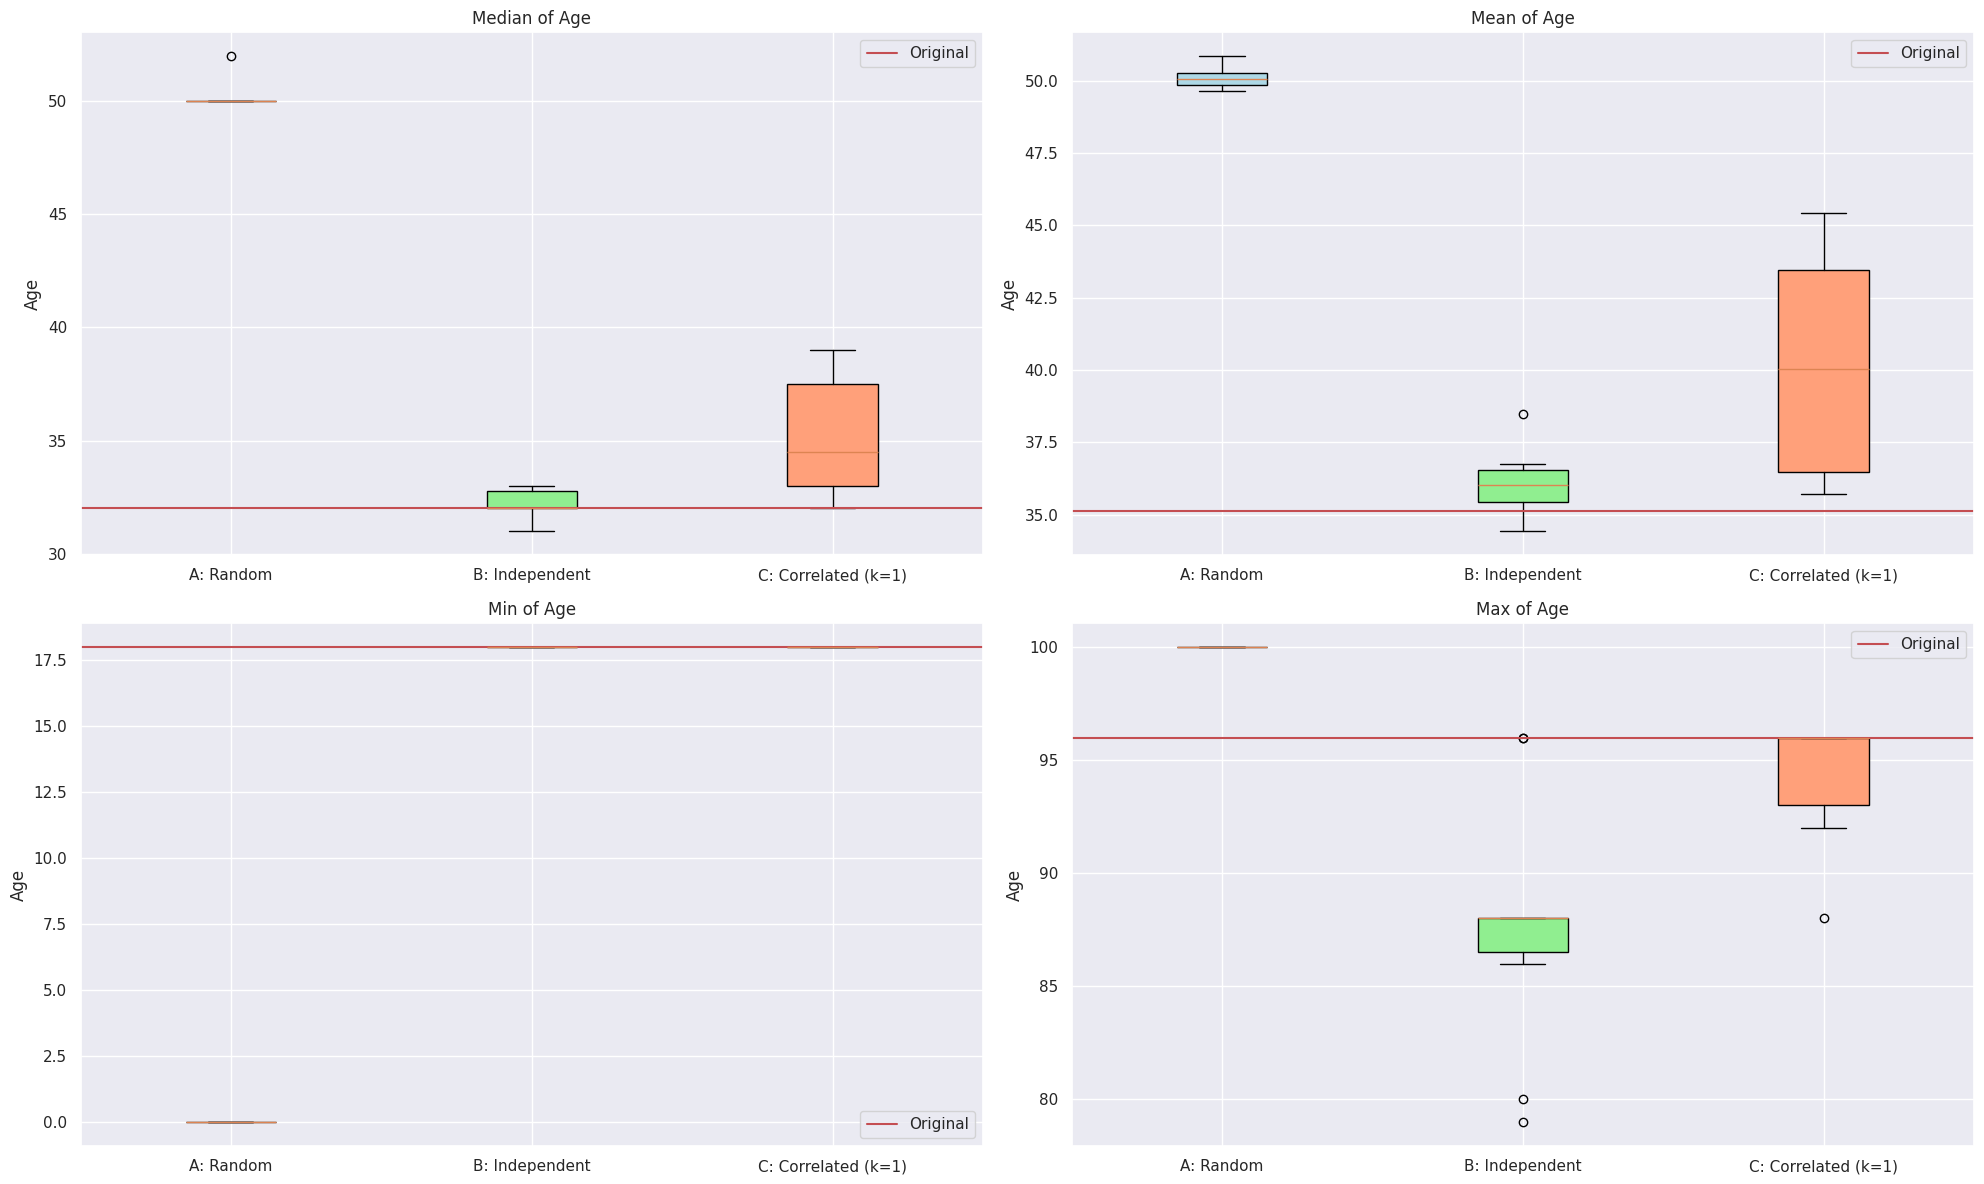

In [14]:
def generate_multiple_datasets(data_file, n_datasets, generator_func, **kwargs):
    """Generate multiple synthetic datasets with different seeds"""
    datasets = []
    for i in range(n_datasets):
        seed = i + 1  # Use different seeds
        datasets.append(generator_func(data_file, output_data_size, seed=seed, **kwargs))
    return datasets

# Generate 10 datasets for each mode
n_datasets = 10
datasets_A = generate_multiple_datasets(real_data_file, n_datasets, generate_data_A)
datasets_B = generate_multiple_datasets(real_data_file, n_datasets, generate_data_B, epsilon=epsilon)
datasets_C = generate_multiple_datasets(real_data_file, n_datasets, generate_data_C, epsilon=epsilon)

# Calculate statistics for each dataset
def calculate_multiple_stats(datasets, attribute):
    """Calculate statistics for multiple datasets"""
    stats = {
        'Median': [],
        'Mean': [],
        'Min': [],
        'Max': []
    }

    for df in datasets:
        stats['Median'].append(df[attribute].median())
        stats['Mean'].append(df[attribute].mean())
        stats['Min'].append(df[attribute].min())
        stats['Max'].append(df[attribute].max())

    return stats

# Calculate statistics for age attribute
stats_A = calculate_multiple_stats(datasets_A, 'age')
stats_B = calculate_multiple_stats(datasets_B, 'age')
stats_C = calculate_multiple_stats(datasets_C, 'age')

# Create box-and-whiskers plots
plt.figure(figsize=(20, 12))
metrics = ['Median', 'Mean', 'Min', 'Max']
ground_truth = {
    'Median': df_real['age'].median(),
    'Mean': df_real['age'].mean(),
    'Min': df_real['age'].min(),
    'Max': df_real['age'].max()
}

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)

    # Prepare data for boxplot
    data = [stats_A[metric], stats_B[metric], stats_C[metric]]

    # Create boxplot
    bp = plt.boxplot(data, labels=['A: Random', 'B: Independent', 'C: Correlated (k=1)'],
                    patch_artist=True)

    # Add ground truth line
    plt.axhline(y=ground_truth[metric], color='r', linestyle='-', label='Original')

    # Set colors for boxes
    colors = ['lightblue', 'lightgreen', 'lightsalmon']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.ylabel('Age')
    plt.title(f'{metric} of Age')
    plt.legend()

plt.tight_layout()
plt.show()

The age statistics across multiple synthetic datasets show independent mode (B) provides the most consistent and accurate reproduction of central tendency (median and mean), with minimal variability. Random mode (A) shows both high bias and variability, while correlated mode (C) has moderate variability but systematic bias toward higher ages.
For extremes, correlated mode better preserves maximum values, while all methods struggle with perfect minimum value preservation.


## Part (c)

Study how accuracy of Q3 changes for case **C**, as you vary __epsilon__ = [0.01, 0.02, ..., 0.1].

================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attrib

<ipython-input-15-446e332dc50e>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=[str(eps) for eps in epsilons_mst_kl])
<ipython-input-15-446e332dc50e>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=[str(eps) for eps in epsilons_mst_kl])
<ipython-input-15-446e332dc50e>:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=[str(eps) for eps in epsilons_mst_kl])


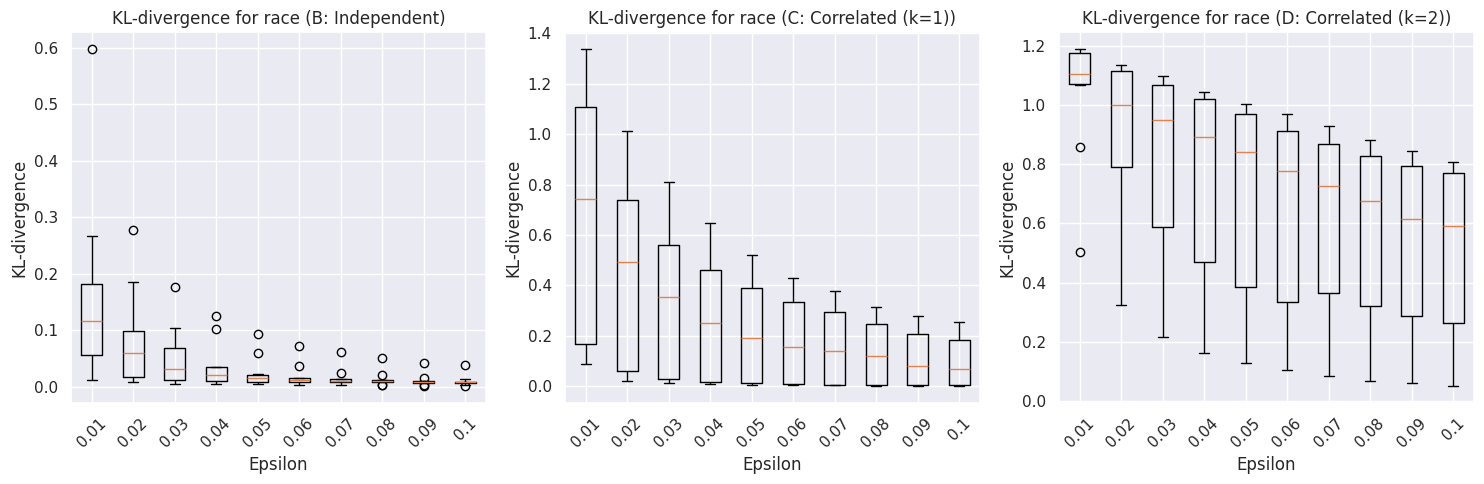

In [15]:
#KL-divergence over the attribute race in hw_compas
epsilons_mst_kl = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
iters = 10

# Function to generate multiple datasets and calculate KL-divergence
def calculate_kl_for_multiple_epsilons(data_file, attribute, epsilons, n_samples, generator_funcs):
    """Calculate KL-divergence for multiple epsilons and generator functions"""
    results = {}

    for name, func in generator_funcs.items():
        kl_values = {eps: [] for eps in epsilons}

        for eps in epsilons:
            for i in range(n_samples):
                seed = i + 1
                synthetic_df = func(data_file, output_data_size, epsilon=eps, seed=seed)
                kl_score = kl_test(df_real, synthetic_df, attribute)
                kl_values[eps].append(kl_score)

        results[name] = kl_values

    return results

# Define generator functions
generator_funcs = {
    'B: Independent': generate_data_B,
    'C: Correlated (k=1)': generate_data_C,
    'D: Correlated (k=2)': generate_data_D
}

# Calculate KL-divergence for race attribute
kl_results = calculate_kl_for_multiple_epsilons(
    real_data_file, 'race', epsilons_mst_kl, iters, generator_funcs
)

# Plot KL-divergence results
plt.figure(figsize=(15, 5))

for i, (name, results) in enumerate(kl_results.items()):
    plt.subplot(1, 3, i+1)

    # Prepare data for boxplot
    data = [results[eps] for eps in epsilons_mst_kl]

    # Create boxplot
    bp = plt.boxplot(data, labels=[str(eps) for eps in epsilons_mst_kl])

    plt.xlabel('Epsilon')
    plt.ylabel('KL-divergence')
    plt.title(f'KL-divergence for race ({name})')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The KL-divergence analysis for race shows a clear decreasing trend as epsilon increases across all methods. Independent mode consistently outperforms correlated modes across all privacy budgets. Higher model complexity (k=2 vs k=1) counterintuitively decreases accuracy under the same privacy constraints.
For mutual information preservation, similar patterns emerge, suggesting simpler models may be more effective under differential privacy constraints, especially at lower epsilon values.

#### Mutual Information Plot for MST
Again, replicate your plots from Part (c) for MST, this time for mutual information, on both hw_compas and hw_fake (df_real and df_fake), varying epsilon = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]. Compare this plot to the plot of dataset **D** (df_real_D). Once again, you need only generate **5 datasets** per epsilon (i.e., run 5 iterations per epsilon).

##HW_compas##

================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute race
Adding attribute sex
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute race
Adding attribute age
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute race
Adding attr

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute race
Adding attribute age
Adding attribute score
========================== BN constructed ==========================
========

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute race
Adding attribute score
Adding attribute sex
========================== BN constructed ==========================
================ Constructing

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
========

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
========

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age
Adding attribute race
========================== BN constructed ==========================
================ Constructing 

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT sex
Adding attribute score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute sex
Adding attribute score
Adding attribute age
========================== BN constructed ==========================
================ Constructing

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT race
Adding attribute score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score
Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing 

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT age
Adding attribute score


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute sex
Adding attribute race
Adding attribute age
========================== BN constructed ==========================
========

/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT score
Adding attribute age


/usr/local/lib/python3.11/dist-packages/DataSynthesizer/lib/PrivBayes.py:193: RuntimeWarning: overflow encountered in exp
  mi_array = np.exp(mi_array)


Adding attribute race
Adding attribute sex
========================== BN constructed ==========================


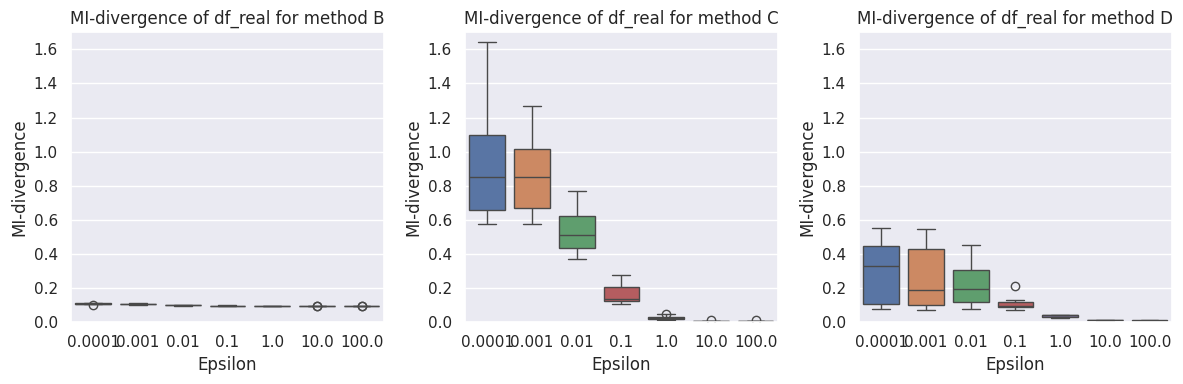

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function
def sum_differences_mi(mi_real, mi_synthetic):
    A = mi_real.values
    B = mi_synthetic.values
    diff = np.abs(A - B)
    i, j = np.triu_indices_from(diff, k=1)
    return diff[i, j].sum()

# Define epsilon values and number of iterations
epsilons_mst_mi = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
iters = 10

# Calculate mutual information for the real dataset
mi_real_df = pairwise_attributes_mutual_information(df_real)

# Initialize results
MIs_real_B = []
MIs_real_C = []
MIs_real_D = []

# Generate synthetic datasets and compute MI differences
for i in range(iters):
    seed = i
    mi_list_B = []
    mi_list_C = []
    mi_list_D = []

    for epsilon in epsilons_mst_mi:
        df_B_temp = generate_data_B(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_C_temp = generate_data_C(real_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_D_temp = generate_data_D(real_data_file, output_data_size, epsilon=epsilon, seed=seed)

        mi_B_temp = pairwise_attributes_mutual_information(df_B_temp)
        mi_C_temp = pairwise_attributes_mutual_information(df_C_temp)
        mi_D_temp = pairwise_attributes_mutual_information(df_D_temp)

        mi_list_B.append(sum_differences_mi(mi_real_df, mi_B_temp))
        mi_list_C.append(sum_differences_mi(mi_real_df, mi_C_temp))
        mi_list_D.append(sum_differences_mi(mi_real_df, mi_D_temp))


    MIs_real_B.append(mi_list_B)
    MIs_real_C.append(mi_list_C)
    MIs_real_D.append(mi_list_D)


# Convert results to DataFrames
MIs_real_B_df = pd.DataFrame(MIs_real_B, columns=epsilons_mst_mi)
MIs_real_C_df = pd.DataFrame(MIs_real_C, columns=epsilons_mst_mi)
MIs_real_D_df = pd.DataFrame(MIs_real_D, columns=epsilons_mst_mi)

# Plot directly
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=MIs_real_B_df)
plt.title('MI-divergence of df_real for method B')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)

plt.subplot(1, 3, 2)
sns.boxplot(data=MIs_real_C_df)
plt.title('MI-divergence of df_real for method C')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)

plt.subplot(1, 3, 3)
sns.boxplot(data=MIs_real_D_df)
plt.title('MI-divergence of df_real for method D')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)

plt.tight_layout()
plt.show()



The mutual information divergence for hw_compas shows pronounced differences between methods. Method B (independent) maintains extremely low divergence (below 0.1) across all epsilon values with minimal variation, indicating it preserves almost no mutual information regardless of privacy settings. Method C (correlated, k=1) exhibits high initial divergence (0.6-1.1) at strict privacy settings, then decreases steadily with increasing epsilon, approaching zero at epsilon values ≥1.0.
Method D (correlated, k=2) shows moderate divergence (0.1-0.4) at low epsilon values with considerable variability, consistently outperforming method C under strict privacy constraints. Both correlated methods converge to near-zero divergence at high epsilon values. Unlike with the race attribute, higher model complexity appears beneficial for preserving mutual information in hw_compas, suggesting that optimal model selection depends on both the specific dataset structure and the particular statistical properties being preserved.

##HW_fake##

================ Constructing Bayesian Network (BN) ================
Adding ROOT parent_1
Adding attribute parent_2
Adding attribute child_2
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute parent_1
Adding attribute parent_2
Adding attribute child_1
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_2
Adding attribute child_1
Adding attribute parent_1
Adding attribute parent_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ================
Adding ROOT child_1
Adding attribute parent_2
Adding attribute parent_1
Adding attribute child_2
========================== BN constructed ==========================
================ Constructing Bayesian Network (BN) ========

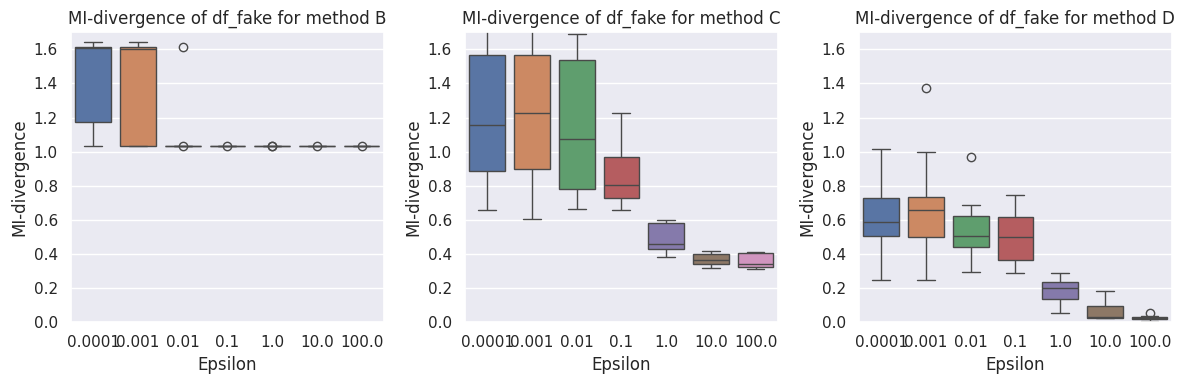

In [28]:
# Calculate mutual information for the real hw_fake dataset
mi_fake_df = pairwise_attributes_mutual_information(df_fake)

# Initialize lists to store results for hw_fake
MIs_fake_B = []
MIs_fake_C = []
MIs_fake_D = []

# Generate synthetic datasets and compute MI differences for hw_fake
for i in range(iters):
    seed = i
    mi_list_B = []
    mi_list_C = []
    mi_list_D = []

    for epsilon in epsilons_mst_mi:
        df_B_temp = generate_data_B(fake_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_C_temp = generate_data_C(fake_data_file, output_data_size, epsilon=epsilon, seed=seed)
        df_D_temp = generate_data_D(fake_data_file, output_data_size, epsilon=epsilon, seed=seed)

        mi_B_temp = pairwise_attributes_mutual_information(df_B_temp)
        mi_C_temp = pairwise_attributes_mutual_information(df_C_temp)
        mi_D_temp = pairwise_attributes_mutual_information(df_D_temp)

        mi_list_B.append(sum_differences_mi(mi_fake_df, mi_B_temp))
        mi_list_C.append(sum_differences_mi(mi_fake_df, mi_C_temp))
        mi_list_D.append(sum_differences_mi(mi_fake_df, mi_D_temp))

    MIs_fake_B.append(mi_list_B)
    MIs_fake_C.append(mi_list_C)
    MIs_fake_D.append(mi_list_D)

# Convert results to DataFrames
MIs_fake_B_df = pd.DataFrame(MIs_fake_B, columns=epsilons_mst_mi)
MIs_fake_C_df = pd.DataFrame(MIs_fake_C, columns=epsilons_mst_mi)
MIs_fake_D_df = pd.DataFrame(MIs_fake_D, columns=epsilons_mst_mi)

# Plot directly, no melting
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=MIs_fake_B_df)
plt.title('MI-divergence of df_fake for method B')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)  # set fixed y-axis

plt.subplot(1, 3, 2)
sns.boxplot(data=MIs_fake_C_df)
plt.title('MI-divergence of df_fake for method C')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)

plt.subplot(1, 3, 3)
sns.boxplot(data=MIs_fake_D_df)
plt.title('MI-divergence of df_fake for method D')
plt.xlabel('Epsilon')
plt.ylabel('MI-divergence')
plt.ylim(0, 1.7)

plt.tight_layout()
plt.show()


The mutual information divergence results for hw_fake show distinct patterns across the three methods. Method B (independent) shows high initial divergence at low epsilon values followed by a flat plateau around 1.0 regardless of privacy budget increases, indicating consistent failure to capture relational information. Method C (correlated, k=1) shows similar high initial divergence but gradually improves with increased epsilon, reaching moderate performance (around 0.4) at highest privacy budgets.

Method D (correlated, k=2) consistently outperforms both other methods across all privacy settings, with substantially lower divergence at strict privacy constraints and near-zero values at high epsilon. This contrasts with the race attribute results, suggesting higher model complexity actually improves performance for preserving relational structures in datasets with explicit parent-child relationships like hw_fake, while simpler models perform better for preserving marginal distributions.